# Classic MCMC

# Problem

- Draw samples from random variable $X$ that follows a complex distribution characterized via the PDF $f_{X}$
- Curse of dimensionality: Traditional MC not scaling to high-dimensional problem settings
- Amount of necessary samples for proper approximations explodes
- Remedy: Use so-called _Markov Chain Monte Carlo_ techniques
- MCMC: Perform Monte Carlo sampling multiple times and always depend on the current state

![asdf](imgs/0000-non-markov.png)

![test](imgs/0001-markov.png)

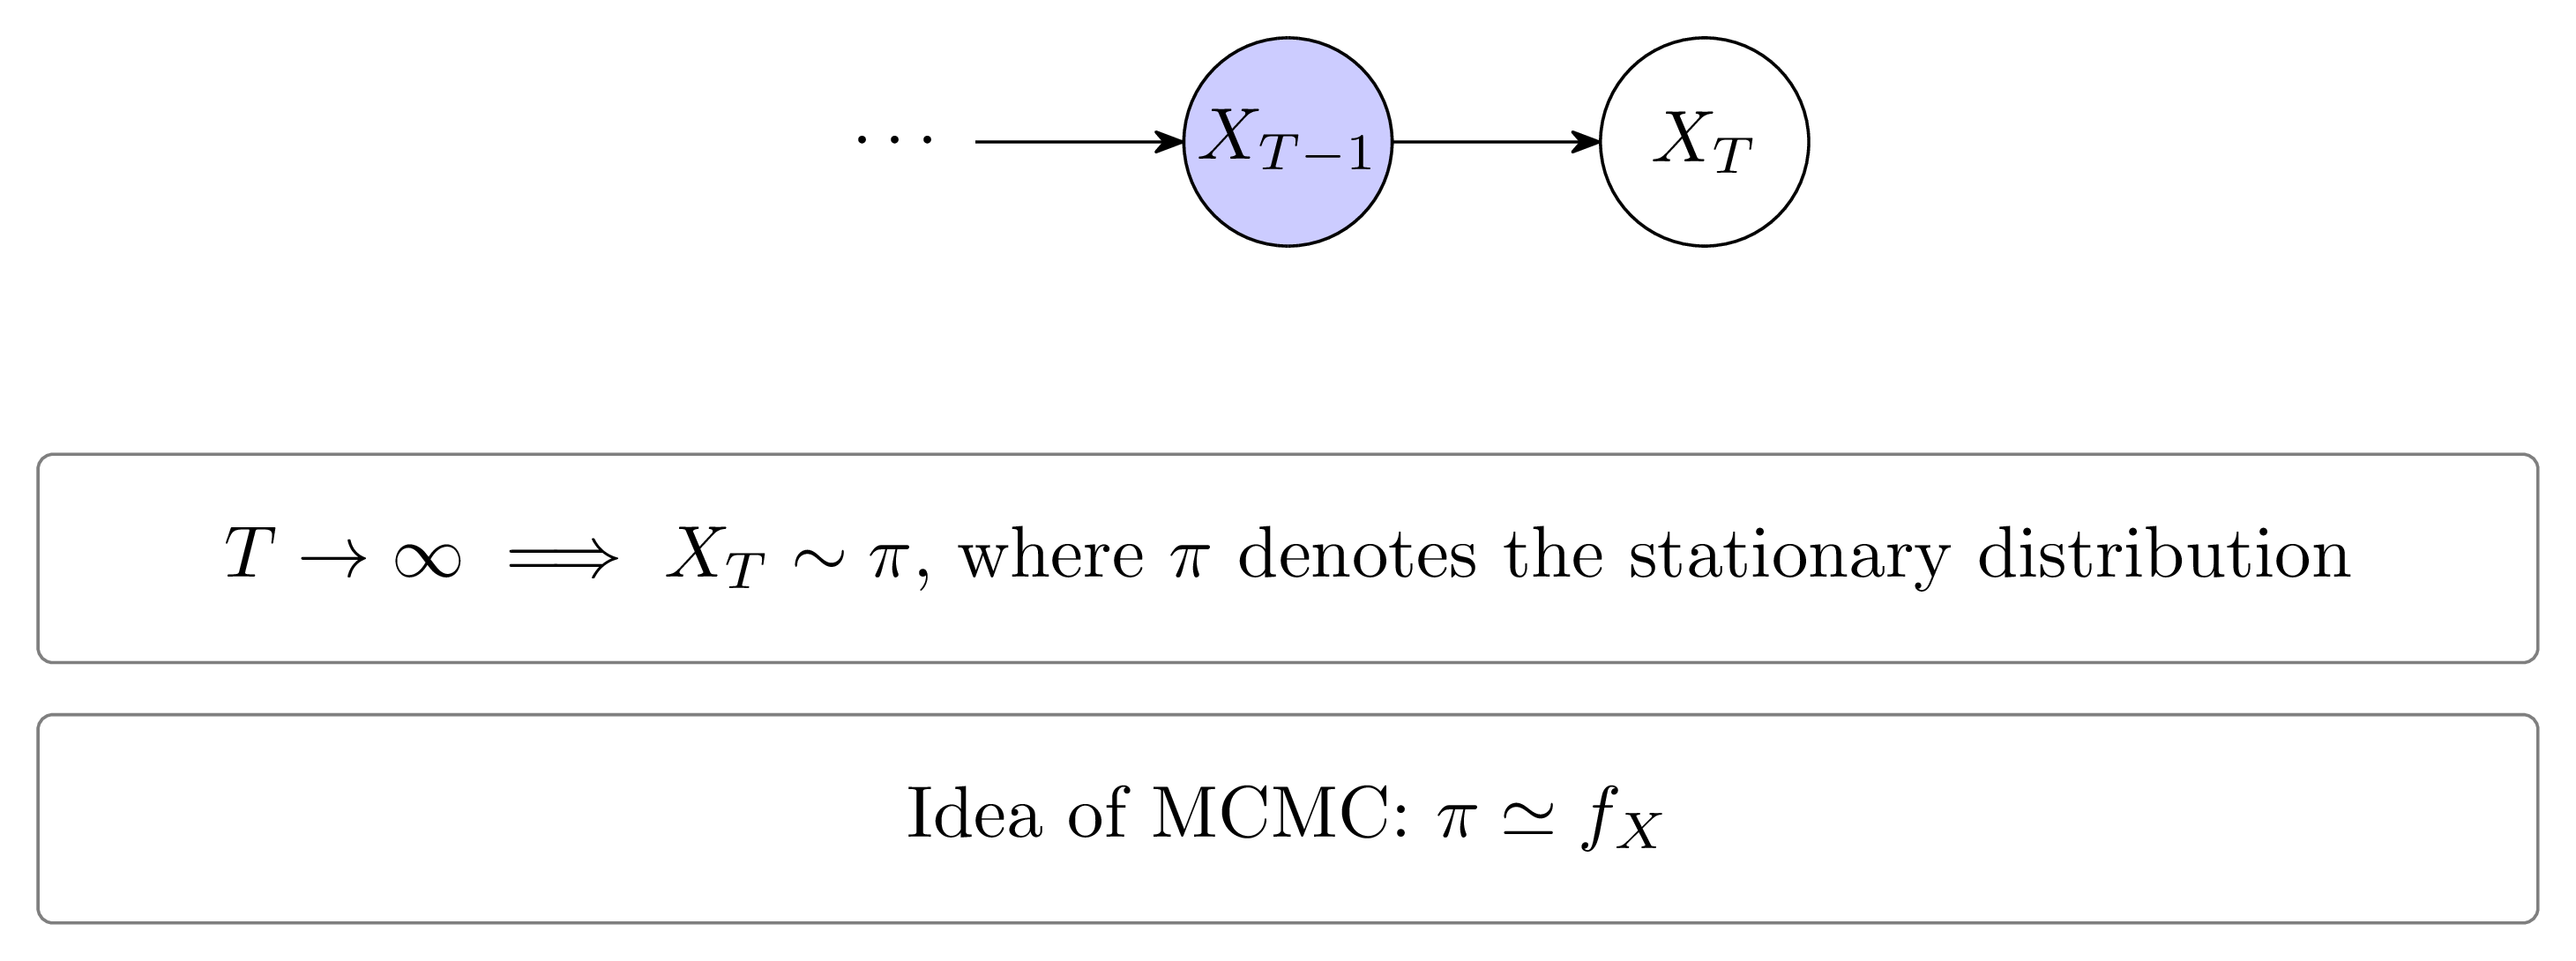![test](imgs/0002-stationary.png)

## Markov Chains

* Used to model relations and dependencies in sequential data
* Model stochastic processes
* Examples: Weather forecasting, language models, gene expression
* Makrov assumption of $n$-th order: Necessary to obtain tractable models
* Mathematically...
$$
p(X_1, X_2, \dots, X_T) = p(X_1) p(X_2 | X_1) \cdots p(X_{T} | X_{T-1})
$$
* $X_1$ is model with a prior probability
* The transition from state $X_{t-1}$ to $X_{t}$ is characterized via the transition distribution/kernel $p(X_{t} | X_{t-1}, \dots, X_{t-n})$
* Typically, $n=1$.

# Markov Chain Monte Carlo

* Original idea introduced by Metropolis and Ulam in 1949
* Metropolis algorithm introduced in 1953
* Metropolis-Hastings algorithm in 1970

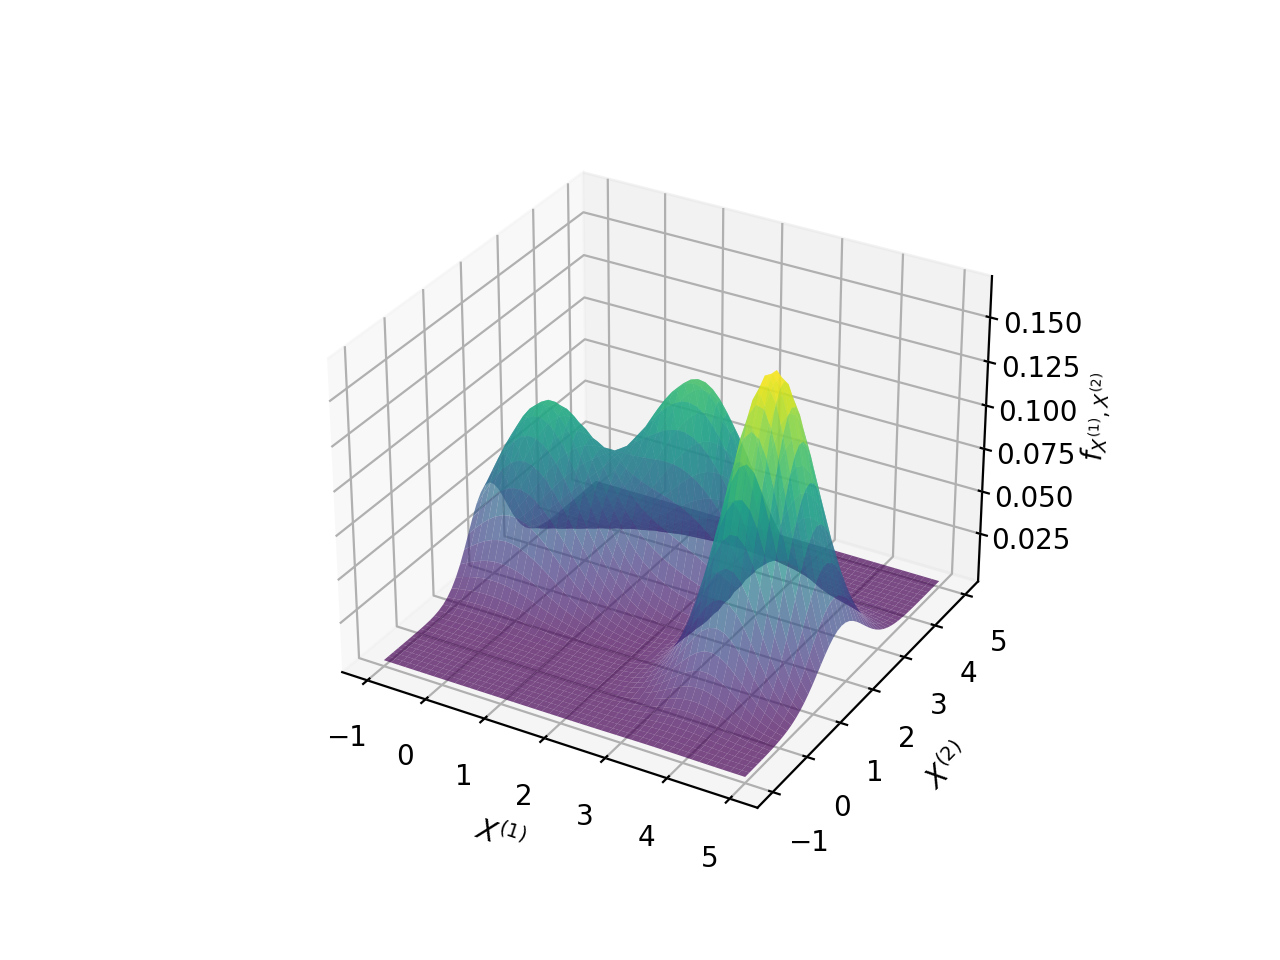

In [1]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np


def squared_mahalanobis_dist(d, metric):
    return np.sum(((d @ metric) * d), axis=-1)


def multivariate_normal_pdf(x, mean, cov):
    scale = 1 / np.sqrt(np.linalg.det(2 * np.pi * cov))
    d = x - np.expand_dims(mean, axis=0)
    metric = np.linalg.inv(cov)
    density = scale * np.exp(-0.5 * squared_mahalanobis_dist(d, metric))
    return density


def gmm(x, alphas, means, covs):
    nr_samples = x.shape[0]
    _, dim = means.shape

    density = np.zeros(nr_samples)

    for alpha, mean, cov in zip(alphas, means, covs):
        density += alpha * multivariate_normal_pdf(x, mean, cov)

    return density

# Make data.
n_points = 50
X1 = np.linspace(-1, 5, n_points)
X2 = np.linspace(-1, 5, n_points)
xx, yy = np.meshgrid(X1, X2)
grid = np.stack([xx.flatten(), yy.flatten()]).T

alphas = np.array([0.3, 0.4, 0.3])
means = np.array([[0, 2], [4, 1.5], [2, 3]])
covs = np.array([[[0.7, 0.1],
                  [0.1, 0.3]],
                 [[0.3, 0.1],
                  [0.1, 0.5]],
                 [[0.8, 0.0],
                  [0.0, 0.2]]])

joint = gmm(grid, alphas, means, covs).reshape(n_points, n_points)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, dpi=200)

surf = ax.plot_surface(xx, yy, joint, antialiased=True, alpha=0.7, cmap="viridis")
ax.set_xlabel(r"$X^{(1)}$")
ax.set_ylabel(r"$X^{(2)}$")
ax.set_zlabel(r"$f_{X^{(1)}, X^{(2)}}$")


# offset = 5 * np.ones_like(X1)
# ax.plot(X1, offset, marginal_X1, c='r', label=r"$f_{X_1}$")

# offset = -1 * np.ones_like(X1)
# ax.plot(offset, X2, marginal_X2, c='b', label=r"$f_{X_2}$")

# Customize the z axis.
# A StrMethodFormatter is used automatically

# Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

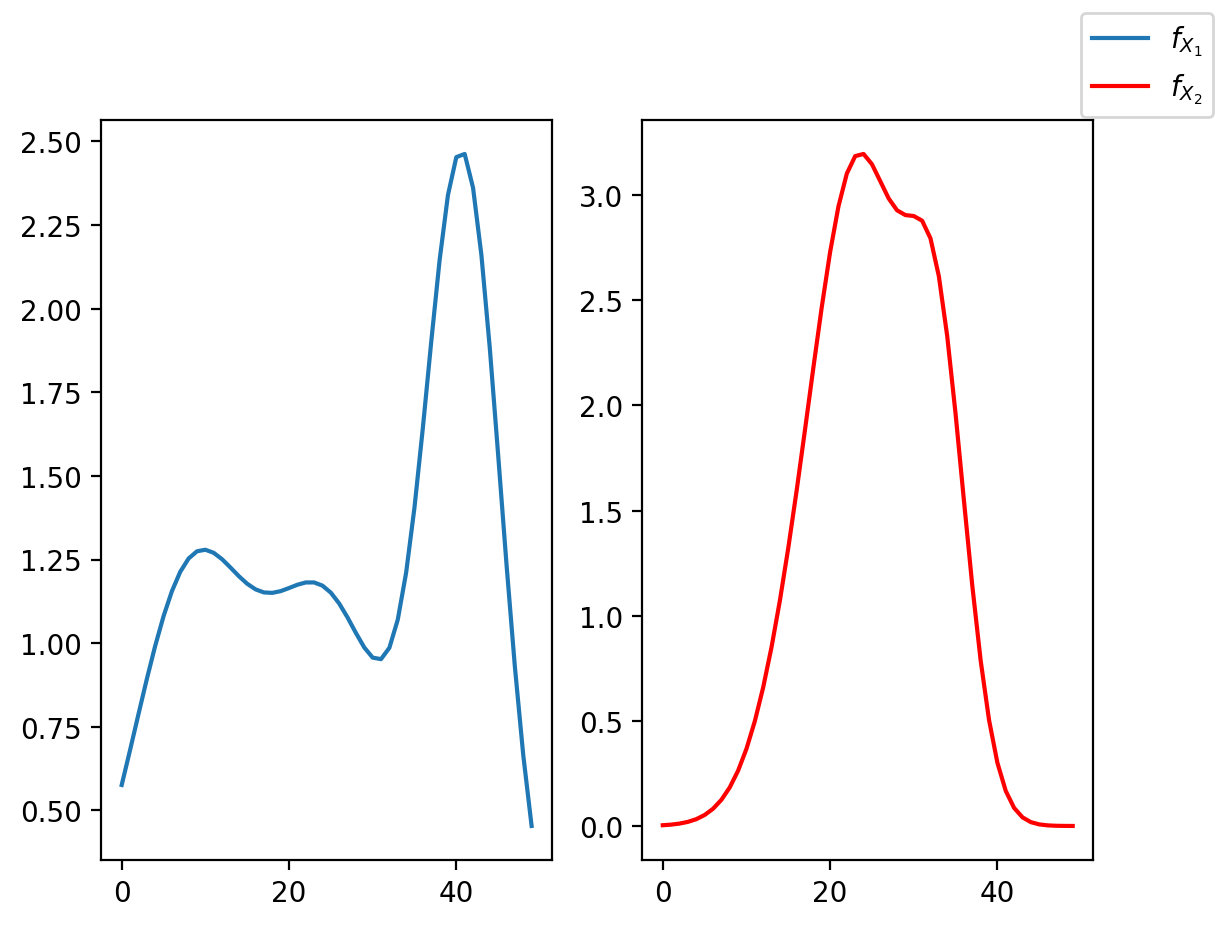

In [12]:
marginal_X1 = np.sum(joint, axis=0)
marginal_X2 = np.sum(joint, axis=1)

fig, ax = plt.subplots(nrows=1, ncols=2, dpi=200)
ax[0].plot(marginal_X1, label=r"$f_{X_1}$")
ax[1].plot(marginal_X2, label=r"$f_{X_2}$", c="r")

fig.legend()
plt.show()